In [57]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [58]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [59]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [4]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_reg_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_reg_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'reg_bias')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'unreg_bias')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly', regex=True)
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf', regex=True)
    
    filtered_cv_results[['C', 'fit_time', 'accuracy', 'n_iter']] = cv_results[[
        'param_C', 'mean_fit_time', 'mean_train_accuracy', 'mean_train_n_iter']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)

    filtered_cv_results['n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)

    return filtered_cv_results

In [38]:
from sklearn.datasets import make_classification, make_blobs

lin_X, lin_y = make_classification(n_samples=100, n_features=1, n_redundant=0, n_informative=1, 
                                   n_clusters_per_class=1, random_state=123456)
nonlin_X, nonlin_y = make_blobs(n_samples=100, n_features=2, random_state=123456)

## Hinge loss

### Primal formulation

In [71]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import plot_svm_hyperplane, plot_model_loss

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [72]:
train_loss_history = defaultdict(dict)

def primal_accuracy_scorer(svc, X, y):
    if hasattr(svc, 'train_loss_history'):
        
        from optiml.ml.svm import DualSVC
        from optiml.ml.svm.kernels import LinearKernel
        
        dual_svc = DualSVC(loss=hinge, 
                           kernel=LinearKernel(), 
                           C=svc.C, 
                           reg_intercept=True, 
                           optimizer='cvxopt').fit(lin_X, lin_y)
        f_star = np.full_like(svc.train_loss_history, svc.loss(np.append(dual_svc.coef_, dual_svc.intercept_)))
        # (f_t - f^*) / f^*
        train_loss_history[svc.momentum_type][svc.C] = np.divide((svc.train_loss_history - f_star), 
                                                                 np.maximum(abs(f_star), 1))
        
    return {'accuracy': svc.score(X, y),
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(lin_X)) <= 1).ravel())}

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -1.5135e+01 -1.9462e+02  1e+03  3e+00  2e-15
 1: -8.0587e+00 -1.0592e+02  2e+02  3e-01  1e-15
 2: -2.8883e+00 -2.1673e+01  2e+01  3e-02  3e-15
 3: -3.6348e+00 -1.0145e+01  8e+00  9e-03  1e-15
 4: -4.0613e+00 -7.1118e+00  3e+00  7e-04  8e-16
 5: -4.3214e+00 -6.8245e+00  3e+00  4e-04  6e-16
 6: -4.7513e+00 -5.7278e+00  1e+00  4e-05  7e-16
 7: -5.0407e+00 -5.3096e+00  3e-01  2e-16  7e-16
 8: -5.1358e+00 -5.1699e+00  3e-02  2e-16  8e-16
 9: -5.1498e+00 -5.1516e+00  2e-03  2e-16  8e-16
10: -5.1506e+00 -5.1506e+00  2e-05  2e-16  8e-16
11: -5.1506e+00 -5.1506e+00  2e-07  2e-16  8e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.5135e+01 -1.9462e+02  1e+03  3e+00  2e-15
 1: -8.0587e+00 -1.0592e+02  2e+02  3e-01  1e-15
 2: -2.8883e+00 -2.1673e+01  2e+01  3e-02  3e-15
 3: -3.6348e+00 -1.0145e+01  8e+00  9e-03  1e-15
 4: -4.0613e+00 -7.1118e+00  3e+00  7

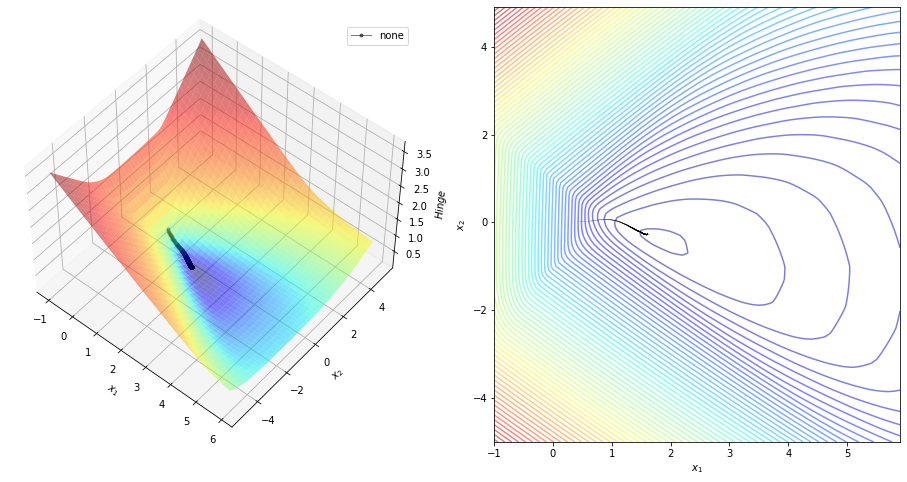

In [73]:
grid = GridSearchCV(PrimalSVC(loss=hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='none', 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss = plot_surface_contour(grid.best_estimator_.loss, 
                                  x_min=-1, 
                                  x_max=6, 
                                  y_min=-5, 
                                  y_max=5)
hinge_loss_opt = plot_trajectory_optimization(hinge_loss, 
                                              grid.best_estimator_.optimizer, 
                                              color='k', 
                                              label='none')

In [74]:
none_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
none_primal_svc_hinge_cv_results.insert(1, 'momentum', 'none')
none_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
none_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.297494      0.99    1000     9
                10   0.347635      0.99    1000     3
                100  0.058554      0.99     110     2

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -1.5135e+01 -1.9462e+02  1e+03  3e+00  2e-15
 1: -8.0587e+00 -1.0592e+02  2e+02  3e-01  1e-15
 2: -2.8883e+00 -2.1673e+01  2e+01  3e-02  3e-15
 3: -3.6348e+00 -1.0145e+01  8e+00  9e-03  1e-15
 4: -4.0613e+00 -7.1118e+00  3e+00  7e-04  8e-16
 5: -4.3214e+00 -6.8245e+00  3e+00  4e-04  6e-16
 6: -4.7513e+00 -5.7278e+00  1e+00  4e-05  7e-16
 7: -5.0407e+00 -5.3096e+00  3e-01  2e-16  7e-16
 8: -5.1358e+00 -5.1699e+00  3e-02  2e-16  8e-16
 9: -5.1498e+00 -5.1516e+00  2e-03  2e-16  8e-16
10: -5.1506e+00 -5.1506e+00  2e-05  2e-16  8e-16
11: -5.1506e+00 -5.1506e+00  2e-07  2e-16  8e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.5135e+01 -1.9462e+02  1e+03  3e+00  2e-15
 1: -8.0587e+00 -1.0592e+02  2e+02  3e-01  1e-15
 2: -2.8883e+00 -2.1673e+01  2e+01  3e-02  3e-15
 3: -3.6348e+00 -1.0145e+01  8e+00  9e-03  1e-15
 4: -4.0613e+00 -7.1118e+00  3e+00  7

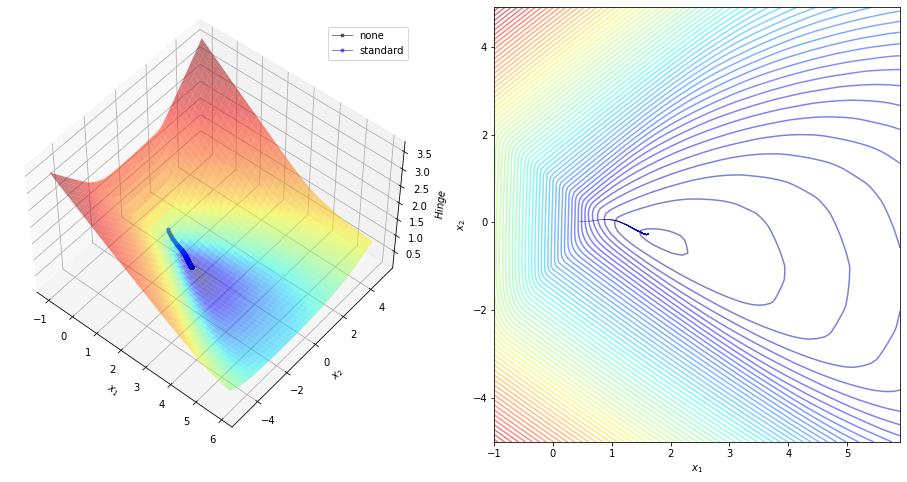

In [75]:
grid = GridSearchCV(PrimalSVC(loss=hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='polyak', 
                              momentum=0.4, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, 
                                              grid.best_estimator_.optimizer, 
                                              color='b', 
                                              label='polyak')
hinge_loss_opt

In [76]:
polyak_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
polyak_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
polyak_primal_svc_hinge_cv_results.insert(1, 'momentum', 'polyak')
polyak_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
polyak_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    standard 1    0.196568      0.99     702     8
                10   0.300704      0.99    1000     3
                100  0.083748      0.99     102     2

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -1.5135e+01 -1.9462e+02  1e+03  3e+00  2e-15
 1: -8.0587e+00 -1.0592e+02  2e+02  3e-01  1e-15
 2: -2.8883e+00 -2.1673e+01  2e+01  3e-02  3e-15
 3: -3.6348e+00 -1.0145e+01  8e+00  9e-03  1e-15
 4: -4.0613e+00 -7.1118e+00  3e+00  7e-04  8e-16
 5: -4.3214e+00 -6.8245e+00  3e+00  4e-04  6e-16
 6: -4.7513e+00 -5.7278e+00  1e+00  4e-05  7e-16
 7: -5.0407e+00 -5.3096e+00  3e-01  2e-16  7e-16
 8: -5.1358e+00 -5.1699e+00  3e-02  2e-16  8e-16
 9: -5.1498e+00 -5.1516e+00  2e-03  2e-16  8e-16
10: -5.1506e+00 -5.1506e+00  2e-05  2e-16  8e-16
11: -5.1506e+00 -5.1506e+00  2e-07  2e-16  8e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.5135e+01 -1.9462e+02  1e+03  3e+00  2e-15
 1: -8.0587e+00 -1.0592e+02  2e+02  3e-01  1e-15
 2: -2.8883e+00 -2.1673e+01  2e+01  3e-02  3e-15
 3: -3.6348e+00 -1.0145e+01  8e+00  9e-03  1e-15
 4: -4.0613e+00 -7.1118e+00  3e+00  7

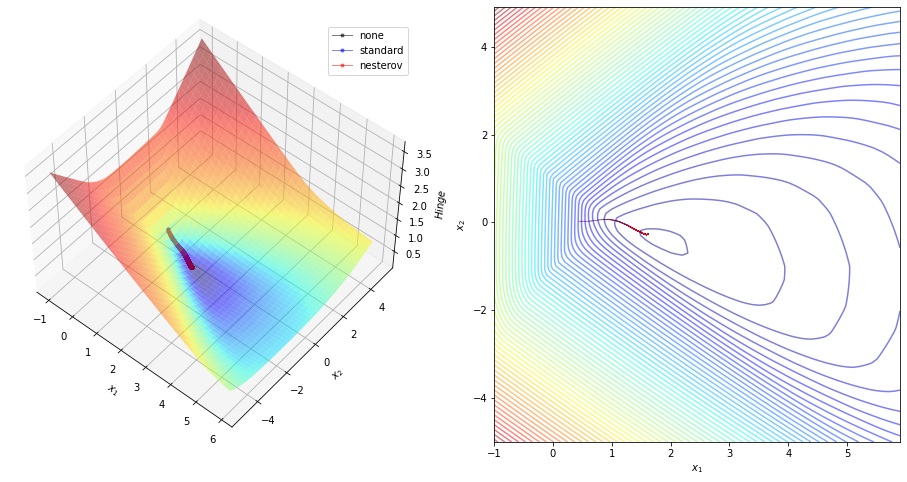

In [77]:
grid = GridSearchCV(PrimalSVC(loss=hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='nesterov', 
                              momentum=0.4, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, 
                                              grid.best_estimator_.optimizer, 
                                              color='r', 
                                              label='nesterov')
hinge_loss_opt.savefig('./tex/img/l1_svc_loss.png')
hinge_loss_opt

In [78]:
nesterov_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svc_hinge_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
nesterov_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    nesterov 1    0.174942      0.99     633     8
                10   0.313584      0.99    1000     3
                100  0.005410      0.99       7     1

In [79]:
custom_primal_svc_hinge_cv_results = none_primal_svc_hinge_cv_results.append(
    polyak_primal_svc_hinge_cv_results).append(
    nesterov_primal_svc_hinge_cv_results)
custom_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.297494      0.99    1000     9
                10   0.347635      0.99    1000     3
                100  0.058554      0.99     110     2
       standard 1    0.196568      0.99     702     8
                10   0.300704      0.99    1000     3
                100  0.083748      0.99     102     2
       nesterov 1    0.174942      0.99     633     8
                10   0.313584      0.99    1000     3
                100  0.005410      0.99       7     1

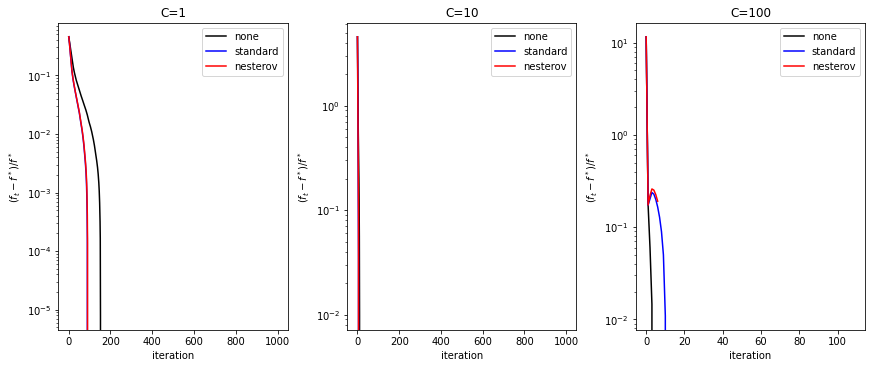

In [80]:
colors = {'none': 'k',
          'polyak': 'b',
          'nesterov': 'r'}
axes = plt.figure(figsize=(12, 5), constrained_layout=True).subplots(1, 3)
for momentum, _dict in train_loss_history.items():
    for (C, history), loss in zip(_dict.items(), axes):
        loss.plot(history, color=colors[momentum])
        loss.set_title('C={:d}'.format(C))
        loss.set_xlabel('t')
        loss.set_ylabel('$(f_t - f^*) / f^*$')
        loss.set_yscale('log')
        loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/l1_svc_loss_history.png')

In [70]:
grid = GridSearchCV(SkLinearSVC(loss='hinge', 
                                random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [17]:
liblinear_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
liblinear_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
liblinear -        1    0.001247      0.99     113     7
                   10   0.001300      0.99     154     2
                   100  0.001597      0.99    1000     3

In [18]:
primal_svc_hinge_cv_results = custom_primal_svc_hinge_cv_results.append(liblinear_primal_svc_hinge_cv_results)
primal_svc_hinge_cv_results.to_latex('./tex/experiments/primal_l1_svc.tex', 
                                     caption='Primal $\protect \mathcal{L}_1$-SVC results', 
                                     label='primal_l1_svc_cv_results', position='H')
primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
sgd       none     1    0.350354      0.99    1000     8
                   10   0.146866      0.99     307     3
                   100  0.069029      0.99     101     2
          standard 1    0.325039      0.99     846     6
                   10   0.139058      0.99     212     3
                   100  0.058884      0.99     101     2
          nesterov 1    0.316183      0.99     860     6
                   10   0.112816      0.99     193     3
                   100  0.007716      0.99       7     1
liblinear -        1    0.001247      0.99     113     7
                   10   0.001300      0.99     154     2
                   100  0.001597      0.99    1000     3

### Dual formulations

In [19]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.svm.kernels import LinearKernel, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.constrained._base import LagrangianQuadratic
from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [20]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT


class SklSVC(SVC):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [23]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def dual_accuracy_scorer(svc, X, y):
    if isinstance(svc.obj, LagrangianQuadratic):
        dual_svc = DualSVC(loss=hinge, 
                           kernel=svc.kernel, 
                           C=svc.C, 
                           reg_intercept=svc.reg_intercept, 
                           optimizer='cvxopt')
        if isinstance(svc.kernel, LinearKernel):
            dual_svc.fit(lin_X, lin_y)
        else:
            dual_svc.fit(nonlin_X, nonlin_y)
        f_star = np.full_like(svc.train_loss_history, dual_svc.obj(dual_svc.alphas_))
        # (t, (f_t - f^*) / f^*)
        dual = 'reg_bias' if svc.reg_intercept else 'unreg_bias'
        train_loss_history[dual][svc.kernel.__class__.__name__][svc.C] = (svc.train_time_history, 
                                                                          np.divide((svc.train_loss_history - f_star), 
                                                                                    np.maximum(abs(f_star), 1)))
        
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SklSVC) else (svc.iter if isinstance(svc.optimizer, str) 
                                                                   else svc.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svc.support_)}

#### Wolfe Dual

##### Linear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


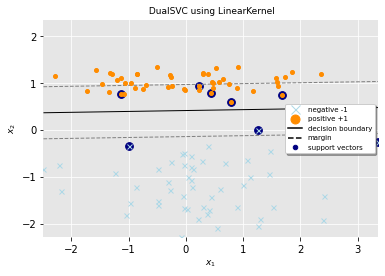

In [32]:
grid = GridSearchCV(DualSVC(loss=hinge, 
                            kernel=LinearKernel()),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)
plt.savefig('./tex/img/linear_dual_l1_svc_hyperplane.png')

In [33]:
custom_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
custom_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
custom_linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
cvxopt 1    0.028596      0.99      10     8
       10   0.039179      0.99      10     5
       100  0.040263      0.99      10    31
smo    1    0.080608      0.99      23     8
       10   0.138384      0.98      24     5
       100  0.256284      0.98      85     5

In [34]:
grid = GridSearchCV(SklSVC(kernel='linear', 
                           verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[LibSVM]

In [35]:
libsvm_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
libsvm_linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
libsvm 1    0.005486      0.99      31     8
       10   0.006457      0.99     245     5
       100  0.006168      0.99    1736     5

In [36]:
linear_dual_svc_cv_results = custom_linear_dual_svc_cv_results.append(libsvm_linear_dual_svc_cv_results)
linear_dual_svc_cv_results.sort_values(['solver'], ascending=False, inplace=True)
linear_dual_svc_cv_results.to_latex('./tex/experiments/linear_dual_l1_svc.tex', 
                                    caption='Wolfe Dual linear $\protect \mathcal{L}_1$-SVC results', 
                                    label='linear_dual_l1_svc_cv_results', position='H')
linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
smo    1    0.080608      0.99      23     8
       10   0.138384      0.98      24     5
       100  0.256284      0.98      85     5
libsvm 1    0.005486      0.99      31     8
       10   0.006457      0.99     245     5
       100  0.006168      0.99    1736     5
cvxopt 1    0.028596      0.99      10     8
       10   0.039179      0.99      10     5
       100  0.040263      0.99      10    31

##### Nonlinear

In [39]:
grid = GridSearchCV(DualSVC(loss=hinge),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/poly_dual_l1_svc_hyperplane.png')

Fitting 1 folds for each of 6 candidates, totalling 6 fits


NotFittedError: All estimators failed to fit

In [41]:
poly_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
poly_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
poly_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt poly   1    0.292866    0.6775      10    31
              10   0.317473    0.9475      10    10
              100  0.309560    0.9775      10     6
smo    poly   1    0.394293    0.6825     143    30
              10   0.301946    0.9475      65    10
              100  0.216001    0.9775      38     6

Fitting 1 folds for each of 6 candidates, totalling 6 fits


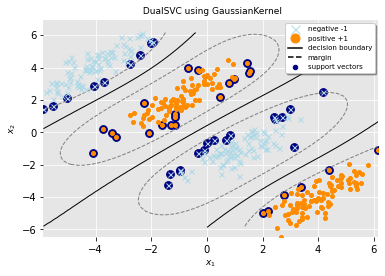

In [42]:
grid = GridSearchCV(DualSVC(loss=hinge),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/gaussian_dual_l1_svc_hyperplane.png')

In [43]:
rbf_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
rbf_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
rbf_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt rbf    1    0.249617       1.0      10    49
              10   0.232780       1.0      10    14
              100  0.257583       1.0      10    17
smo    rbf    1    0.360697       1.0      66    51
              10   0.252868       1.0      38    13
              100  0.275172       1.0      56    12

In [44]:
custom_nonlinear_dual_svc_cv_results = poly_nonlinear_dual_svc_cv_results.append(rbf_nonlinear_dual_svc_cv_results)
custom_nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
custom_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt poly   1    0.292866    0.6775      10    31
              10   0.317473    0.9475      10    10
              100  0.309560    0.9775      10     6
       rbf    1    0.249617    1.0000      10    49
              10   0.232780    1.0000      10    14
              100  0.257583    1.0000      10    17
smo    poly   1    0.394293    0.6825     143    30
              10   0.301946    0.9475      65    10
              100  0.216001    0.9775      38     6
       rbf    1    0.360697    1.0000      66    51
              10   0.252868    1.0000      38    13
              100  0.275172    1.0000      56    12

In [45]:
grid = GridSearchCV(SklSVC(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [1],
                                 'gamma': ['scale']},
                                {'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[LibSVM]

In [46]:
libsvm_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svc_cv_results.sort_values(['kernel'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
libsvm poly   1    0.004139       1.0     233    30
              10   0.003570       1.0     118    10
              100  0.005292       1.0      88     6
       rbf    1    0.004747       1.0     252    50
              10   0.003243       1.0     134    13
              100  0.002651       1.0     182    12

In [47]:
nonlinear_dual_svc_cv_results = custom_nonlinear_dual_svc_cv_results.append(libsvm_nonlinear_dual_svc_cv_results)
nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_l1_svc.tex', 
                                       caption='Wolfe Dual nonlinear $\protect \mathcal{L}_1$-SVC results', 
                                       label='nonlinear_dual_l1_svc_cv_results', position='H')
nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
smo    poly   1    0.394293    0.6825     143    30
              10   0.301946    0.9475      65    10
              100  0.216001    0.9775      38     6
       rbf    1    0.360697    1.0000      66    51
              10   0.252868    1.0000      38    13
              100  0.275172    1.0000      56    12
libsvm poly   1    0.004139    1.0000     233    30
              10   0.003570    1.0000     118    10
              100  0.005292    1.0000      88     6
       rbf    1    0.004747    1.0000     252    50
              10   0.003243    1.0000     134    13
              100  0.002651    1.0000     182    12
cvxopt poly   1    0.292866    0.6775      10    31
              10   0.317473    0.9475      10    10
              100  0.309560    0.9775      10     6
       rbf    1    0.249617    1.0000      10    49
              10   0.232780    1.0000      10    14
              100  0.257583    1.0000      10    17

#### Lagrangian Dual

##### Linear

In [109]:
grid = GridSearchCV(DualSVC(loss=hinge, 
                            kernel=LinearKernel(), 
                            optimizer=AdaGrad, 
                            learning_rate=0.001),
                    param_grid={'C': [1, 10, 100],
                                'reg_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits


In [110]:
linear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svc_cv_results.sort_values(['dual'], inplace=True)
linear_lagrangian_dual_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_l1_svc.tex', 
                                               caption='Lagrangian Dual linear $\protect \mathcal{L}_1$-SVC results', 
                                               label='linear_lagrangian_dual_l1_svc_cv_results', position='H')
linear_lagrangian_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       C                                    
reg_bias   1    0.019050     0.985       1   194
           10   0.007226     0.985       1   194
           100  0.015732     0.985       1   194
unreg_bias 1    0.007376     0.985       1   195
           10   0.008295     0.985       1   195
           100  0.017933     0.985       1   195

##### Nonlinear

In [111]:
grid = GridSearchCV(DualSVC(loss=hinge, 
                            optimizer=AdaGrad, 
                            learning_rate=0.001),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'reg_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
     pcost       dcost       gap    pres   dres
 0: -9.2053e+01 -1.1372e+03  7e+03  4e+00  5e-14
 1: -4.5998e+01 -7.6139e+02  1e+03  5e-01  4e-14
 2: -7.7986e+00 -2.4674e+02  4e+02  1e-01  2e-14
 3: -3.3553e+00 -6.4615e+01  7e+01  2e-02  1e-14
 4: -7.4294e+00 -3.2326e+01  3e+01  6e-03  8e-15
 5: -9.0647e+00 -2.6698e+01  2e+01  4e-03  8e-15
 6: -1.0800e+01 -2.1571e+01  1e+01  2e-03  7e-15
 7: -1.1850e+01 -1.8152e+01  7e+00  9e-04  7e-15
 8: -1.2378e+01 -1.6737e+01  5e+00  5e-04  7e-15
 9: -1.3172e+01 -1.5042e+01  2e+00  1e-04  8e-15
10: -1.3441e+01 -1.4572e+01  1e+00  2e-05  8e-15
11: -1.3769e+01 -1.4127e+01  4e-01  6e-06  8e-15
12: -1.3858e+01 -1.4005e+01  1e-01  2e-06  8e-15
13: -1.3915e+01 -1.3935e+01  2e-02  9e-08  9e-15
14: -1.3924e+01 -1.3925e+01  4e-04  1e-09  9e-15
15: -1.3924e+01 -1.3924e+01  6e-06  2e-11  8e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.2053e+01 -1.1372e+03  7e+03 

     pcost       dcost       gap    pres   dres
 0:  6.8484e+02 -1.5493e+04  3e+04  4e-01  1e-14
 1:  7.5551e+02 -1.9923e+03  3e+03  4e-03  1e-14
 2:  9.3148e+01 -2.2877e+02  3e+02  7e-05  1e-14
 3: -5.9875e+00 -4.7278e+01  4e+01  1e-14  4e-15
 4: -1.3243e+01 -3.5954e+01  2e+01  1e-14  3e-15
 5: -1.6311e+01 -3.7967e+01  2e+01  3e-15  3e-15
 6: -1.9721e+01 -3.6359e+01  2e+01  9e-15  3e-15
 7: -1.9314e+01 -3.5941e+01  2e+01  9e-16  3e-15
 8: -2.0956e+01 -3.4950e+01  1e+01  2e-14  3e-15
 9: -2.1463e+01 -3.5389e+01  1e+01  2e-15  3e-15
10: -2.1252e+01 -3.5066e+01  1e+01  2e-14  3e-15
11: -2.4843e+01 -3.4494e+01  1e+01  1e-14  3e-15
12: -2.7435e+01 -3.0654e+01  3e+00  4e-15  4e-15
13: -2.8826e+01 -2.8941e+01  1e-01  1e-15  4e-15
14: -2.8878e+01 -2.8880e+01  2e-03  2e-14  5e-15
15: -2.8879e+01 -2.8879e+01  3e-05  7e-15  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.8484e+02 -1.5493e+04  3e+04  4e-01  1e-14
 1:  7.5551e+02 -1.9923e+03  3e+03  4e-03  1e-1

In [112]:
nonlinear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svc_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_l1_svc.tex', 
                                                  caption='Lagrangian Dual nonlinear $\protect \mathcal{L}_1$-SVC results', 
                                                  label='nonlinear_lagrangian_dual_l1_svc_cv_results', position='H')
nonlinear_lagrangian_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual       kernel C                                    
reg_bias   poly   1    0.999399     0.635     222   317
                  10   0.885449     0.635     222   317
                  100  0.957622     0.635     222   317
           rbf    1    0.098495     1.000       1   399
                  10   0.111226     1.000       1   399
                  100  0.093314     1.000       1   399
unreg_bias poly   1    0.029809     0.640       3   316
                  10   0.117163     0.640       3   316
                  100  0.031291     0.640       3   316
           rbf    1    0.210731     0.860       9   307
                  10   0.146667     0.860       9   307
                  100  0.137591     0.860       9   307

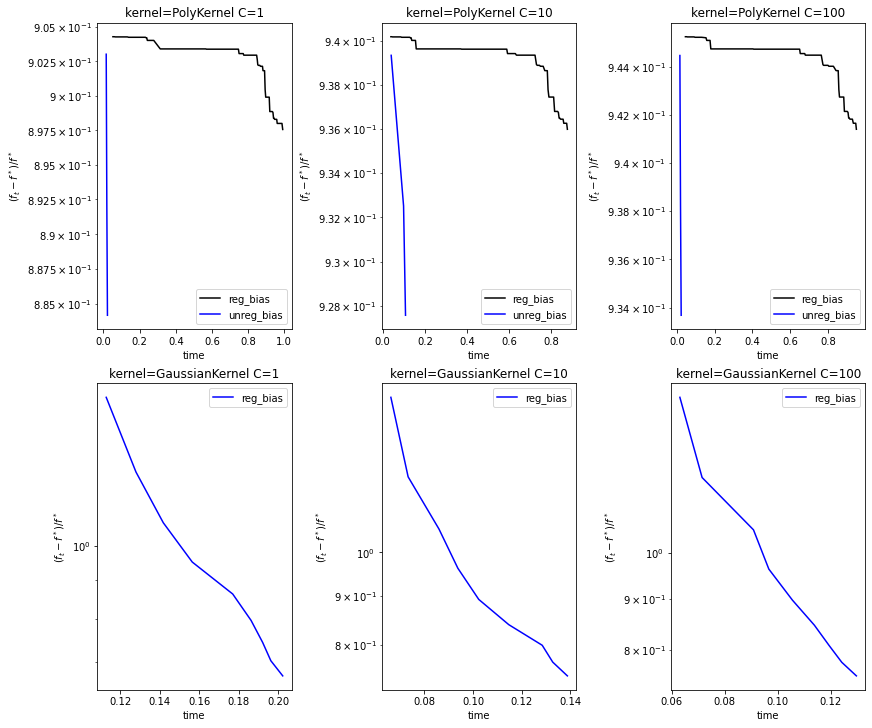

In [113]:
colors = {'reg_bias': 'k',
          'unreg_bias': 'b'}
axes = plt.figure(figsize=(12, 10), constrained_layout=True).subplots(2, 3)  # figsize (12, 15) and subplots (3, 3)
for dual, _dict1 in train_loss_history.items():
    for (kernel, _dict2), row_ax in zip(_dict1.items(), axes):
        for (C, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history[0], history[1], color=colors[dual])
            loss.set_title('kernel={} C={:d}'.format(kernel, C))
            loss.set_xlabel('time')
            loss.set_ylabel('$(f_t - f^*) / f^*$')
            loss.set_yscale('log')
            loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/lagrangian_dual_l1_svc_loss_history.png')

## Squared Hinge loss

### Primal formulation

In [88]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [89]:
train_loss_history = defaultdict(dict)

def primal_accuracy_scorer(svc, X, y):
    if hasattr(svc, 'train_loss_history'):
        
        from optiml.ml.svm import DualSVC
        from optiml.ml.svm.kernels import LinearKernel
        
        dual_svc = DualSVC(loss=squared_hinge, 
                           kernel=LinearKernel(), 
                           C=svc.C, 
                           reg_intercept=True, 
                           optimizer='cvxopt').fit(lin_X, lin_y)
        f_star = np.full_like(svc.train_loss_history, svc.loss(np.append(dual_svc.coef_, dual_svc.intercept_)))
        # (f_t - f^*) / f^*
        train_loss_history[svc.momentum_type][svc.C] = np.divide((svc.train_loss_history - f_star), 
                                                                np.maximum(abs(f_star), 1))
        
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(lin_X)) <= 1).ravel())}

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -8.7083e+00 -2.5323e+01  3e+02  1e+01  2e+00
 1: -7.0720e+00 -2.2457e+01  6e+01  2e+00  3e-01
 2: -4.2036e+00 -1.0649e+01  6e+00  7e-16  5e-15
 3: -5.6786e+00 -6.8708e+00  1e+00  1e-15  2e-15
 4: -6.1629e+00 -6.3636e+00  2e-01  1e-15  1e-15
 5: -6.2895e+00 -6.3065e+00  2e-02  1e-15  1e-15
 6: -6.3022e+00 -6.3029e+00  7e-04  6e-16  1e-15
 7: -6.3027e+00 -6.3027e+00  1e-05  6e-16  1e-15
 8: -6.3027e+00 -6.3027e+00  1e-07  4e-16  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.7083e+00 -2.5323e+01  3e+02  1e+01  2e+00
 1: -7.0720e+00 -2.2457e+01  6e+01  2e+00  3e-01
 2: -4.2036e+00 -1.0649e+01  6e+00  7e-16  5e-15
 3: -5.6786e+00 -6.8708e+00  1e+00  1e-15  2e-15
 4: -6.1629e+00 -6.3636e+00  2e-01  1e-15  1e-15
 5: -6.2895e+00 -6.3065e+00  2e-02  1e-15  1e-15
 6: -6.3022e+00 -6.3029e+00  7e-04  6e-16  1e-15
 7: -6.3027e+00 -6.3027e+00  1e-05  6

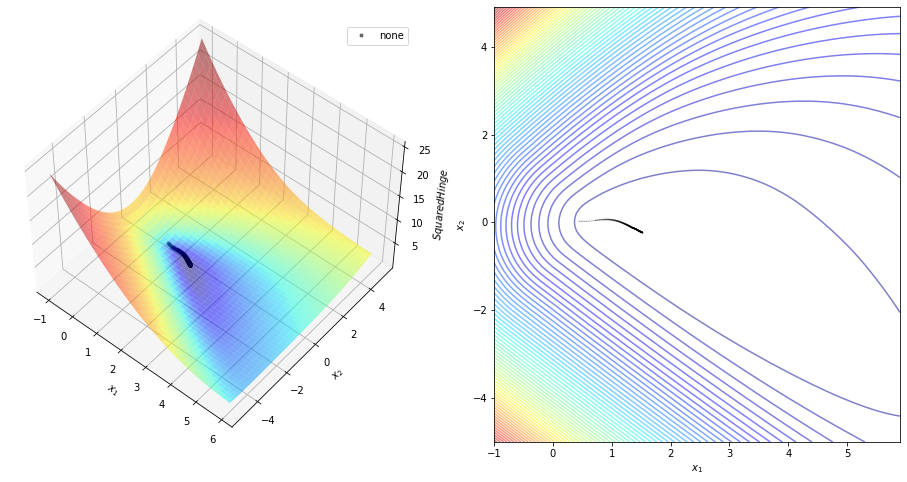

In [90]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='none', 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss = plot_surface_contour(grid.best_estimator_.loss, 
                                          x_min=-1, 
                                          x_max=6, 
                                          y_min=-5, 
                                          y_max=5)
squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss, 
                                                      grid.best_estimator_.optimizer, 
                                                      color='k', 
                                                      label='none')

In [91]:
none_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
none_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'none')
none_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
none_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.135143      0.99     179    11
                10   0.019105      0.99      22     8
                100  0.089293      0.99     128     2

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -8.7083e+00 -2.5323e+01  3e+02  1e+01  2e+00
 1: -7.0720e+00 -2.2457e+01  6e+01  2e+00  3e-01
 2: -4.2036e+00 -1.0649e+01  6e+00  7e-16  5e-15
 3: -5.6786e+00 -6.8708e+00  1e+00  1e-15  2e-15
 4: -6.1629e+00 -6.3636e+00  2e-01  1e-15  1e-15
 5: -6.2895e+00 -6.3065e+00  2e-02  1e-15  1e-15
 6: -6.3022e+00 -6.3029e+00  7e-04  6e-16  1e-15
 7: -6.3027e+00 -6.3027e+00  1e-05  6e-16  1e-15
 8: -6.3027e+00 -6.3027e+00  1e-07  4e-16  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.7083e+00 -2.5323e+01  3e+02  1e+01  2e+00
 1: -7.0720e+00 -2.2457e+01  6e+01  2e+00  3e-01
 2: -4.2036e+00 -1.0649e+01  6e+00  7e-16  5e-15
 3: -5.6786e+00 -6.8708e+00  1e+00  1e-15  2e-15
 4: -6.1629e+00 -6.3636e+00  2e-01  1e-15  1e-15
 5: -6.2895e+00 -6.3065e+00  2e-02  1e-15  1e-15
 6: -6.3022e+00 -6.3029e+00  7e-04  6e-16  1e-15
 7: -6.3027e+00 -6.3027e+00  1e-05  6

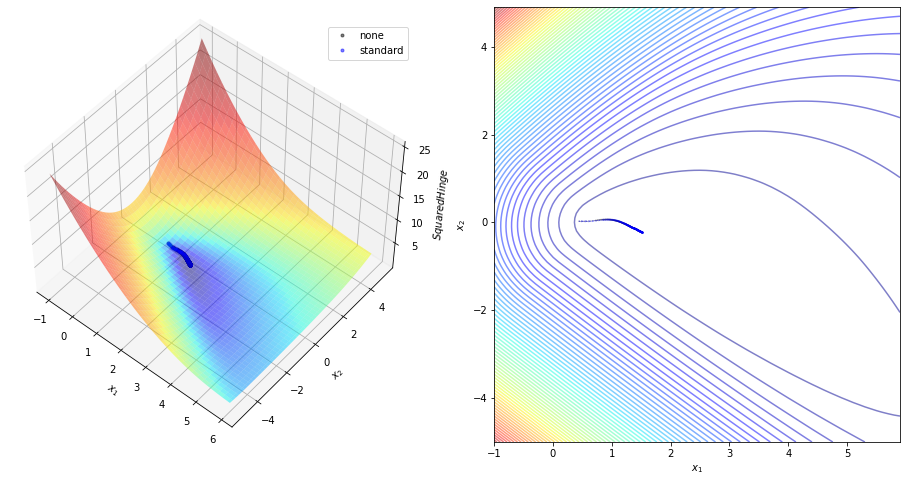

In [92]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='polyak', 
                              momentum=0.4, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, 
                                                      grid.best_estimator_.optimizer, 
                                                      color='b', 
                                                      label='polyak')
squared_hinge_loss_opt

In [93]:
polyak_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
polyak_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
polyak_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'polyak')
polyak_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
polyak_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    standard 1    0.048630      0.99     108    11
                10   0.024990      0.99      16     7
                100  0.015023      0.99       7     1

Fitting 1 folds for each of 3 candidates, totalling 3 fits
     pcost       dcost       gap    pres   dres
 0: -8.7083e+00 -2.5323e+01  3e+02  1e+01  2e+00
 1: -7.0720e+00 -2.2457e+01  6e+01  2e+00  3e-01
 2: -4.2036e+00 -1.0649e+01  6e+00  7e-16  5e-15
 3: -5.6786e+00 -6.8708e+00  1e+00  1e-15  2e-15
 4: -6.1629e+00 -6.3636e+00  2e-01  1e-15  1e-15
 5: -6.2895e+00 -6.3065e+00  2e-02  1e-15  1e-15
 6: -6.3022e+00 -6.3029e+00  7e-04  6e-16  1e-15
 7: -6.3027e+00 -6.3027e+00  1e-05  6e-16  1e-15
 8: -6.3027e+00 -6.3027e+00  1e-07  4e-16  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.7083e+00 -2.5323e+01  3e+02  1e+01  2e+00
 1: -7.0720e+00 -2.2457e+01  6e+01  2e+00  3e-01
 2: -4.2036e+00 -1.0649e+01  6e+00  7e-16  5e-15
 3: -5.6786e+00 -6.8708e+00  1e+00  1e-15  2e-15
 4: -6.1629e+00 -6.3636e+00  2e-01  1e-15  1e-15
 5: -6.2895e+00 -6.3065e+00  2e-02  1e-15  1e-15
 6: -6.3022e+00 -6.3029e+00  7e-04  6e-16  1e-15
 7: -6.3027e+00 -6.3027e+00  1e-05  6

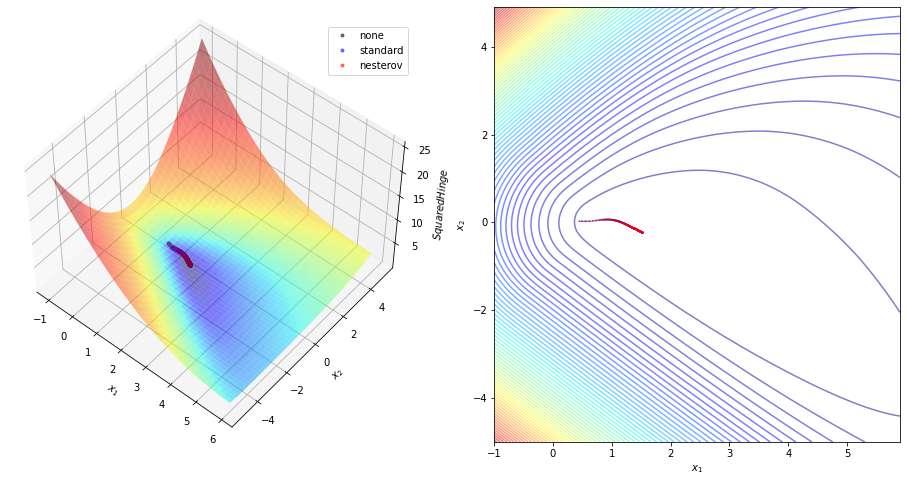

In [94]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='nesterov', 
                              momentum=0.4, 
                              early_stopping=True, 
                              tol=1e-8, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, 
                                                      grid.best_estimator_.optimizer, 
                                                      color='r', 
                                                      label='nesterov')
squared_hinge_loss_opt.savefig('./tex/img/l2_svc_loss.png')
squared_hinge_loss_opt

In [95]:
nesterov_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
nesterov_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    nesterov 1    0.060258      0.99     108    11
                10   0.043480      0.99      26     4
                100  0.009726      0.99       7     1

In [96]:
custom_primal_svc_squared_hinge_cv_results = none_primal_svc_squared_hinge_cv_results.append(
    polyak_primal_svc_squared_hinge_cv_results).append(
    nesterov_primal_svc_squared_hinge_cv_results)
custom_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.135143      0.99     179    11
                10   0.019105      0.99      22     8
                100  0.089293      0.99     128     2
       standard 1    0.048630      0.99     108    11
                10   0.024990      0.99      16     7
                100  0.015023      0.99       7     1
       nesterov 1    0.060258      0.99     108    11
                10   0.043480      0.99      26     4
                100  0.009726      0.99       7     1

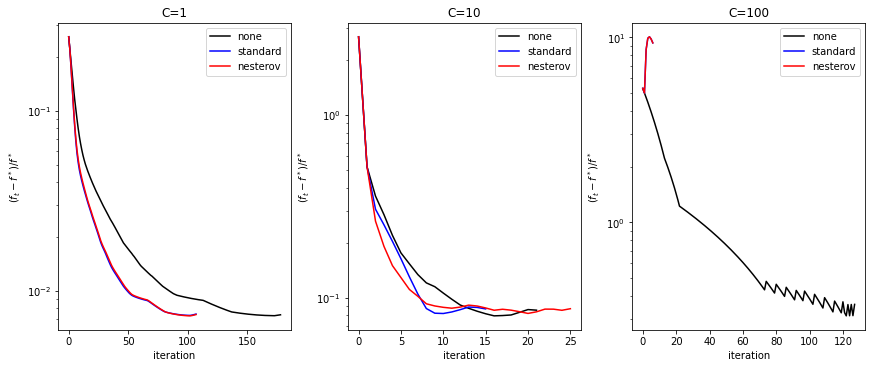

In [97]:
colors = {'none': 'k',
          'polyak': 'b',
          'nesterov': 'r'}
axes = plt.figure(figsize=(12, 5), constrained_layout=True).subplots(1, 3)
for momentum, _dict in train_loss_history.items():
    for (C, history), loss in zip(_dict.items(), axes):
        loss.plot(history, color=colors[momentum])
        loss.set_title('C={:d}'.format(C))
        loss.set_xlabel('t')
        loss.set_ylabel('$(f_t - f^*) / f^*$')
        loss.set_yscale('log')
        loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/l2_svc_loss_history.png')

In [76]:
grid = GridSearchCV(SkLinearSVC(loss='squared_hinge', 
                                random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [77]:
liblinear_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
liblinear_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
liblinear -        1    0.001107      0.99      46    25
                   10   0.001545      0.99     367    18
                   100  0.002628      0.99    1000    22

In [78]:
primal_svc_squared_hinge_cv_results = custom_primal_svc_squared_hinge_cv_results.append(liblinear_primal_svc_squared_hinge_cv_results)
primal_svc_squared_hinge_cv_results.to_latex('./tex/experiments/primal_l2_svc.tex', 
                                             caption='Primal $\protect \mathcal{L}_2$-SVC results', 
                                             label='primal_l2_svc_cv_results', position='H')
primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
sgd       none     1    0.130064      0.99     179    11
                   10   0.035883      0.99      22     8
                   100  0.104132      0.99     128     2
          standard 1    0.065459      0.99     108    11
                   10   0.014336      0.99      16     7
                   100  0.009515      0.99       7     1
          nesterov 1    0.050597      0.99     108    11
                   10   0.028879      0.99      26     4
                   100  0.007417      0.99       7     1
liblinear -        1    0.001107      0.99      46    25
                   10   0.001545      0.99     367    18
                   100  0.002628      0.99    1000    22